## Twitter Dataset Prepare

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import tqdm
import regex
import os
import re
import shutil
import operator
import codecs
import time
import random
from math import log
from nltk import sent_tokenize
from pymystem3 import Mystem
from seaborn import heatmap
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import RussianStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc



from sklearn.ensemble import GradientBoostingClassifier
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

%matplotlib inline

База данных состоит из 12 столбцов:
- id: уникальный номер сообщения в системе twitter;
- tdate: дата публикации сообщения (твита);
- tmane: имя пользователя, опубликовавшего сообщение;
- ttext:  текст сообщения (твита);
- ttype: поле в котором в дальнейшем будет указано к кому классу относится твит (положительный, отрицательный, нейтральный);
- trep: количество реплаев к данному сообщению. В настоящий момент API твиттера не отдает эту информацию;
- trtf: число ретвитов
- tfav: число сколько раз данное сообщение было добавлено в избранное другими пользователями;
- tstcount: число всех сообщений пользователя в сети twitter;
- tfol: количество фоловеров пользователя (тех людей, которые читают пользователя);
- tfrien: количество друзей пользователя (те люди, которых читает пользователь);
- listcount: количество листов-подписок в которые добавлен твиттер-пользователь.

In [2]:
header = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'trtf', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount']

#### Загружаем положительные и негативные твиты в один DataFrame, после этого перемешиваем с помощью sample(frac=1)

In [3]:
pos_twitts = pd.read_csv('train_positive.csv', sep=';', names=header)
neg_twitts = pd.read_csv('train_negative.csv', sep=';', names=header)
twitts = pd.concat([pos_twitts, neg_twitts], axis=0)
twitts = twitts.sample(frac=1)

#### Смотрим размерность нашего размеченного датасета и проверяем, что у нас 2 вида твитов(положительные(1) и негативные(-1))

In [4]:
print twitts.shape
twitts.head()

(226834, 12)


,id,tdate,tmane,ttext,ttype,trep,trtf,tfav,tstcount,tfol,tfrien,listcount
8038,409103511147003904,1386372852,dorokhova_anna_,а где ты будешь праздновать новый год? — с пар...,1,0,0,0,597,1214,30,0
70182,410466817023680512,1386697889,DashaLasVegas,Заболел моей болезнью))) теперь каждый день ки...,1,0,0,0,1716,45,46,0
76946,419136861983223808,1388764989,Ulisoul,"На данный момент, я ненавижу то место где сейч...",-1,0,0,0,5530,45,78,1
34507,413324014661013504,1387379098,Didiandra,Столько вопросов.. я хочу вернуть обратно мели...,-1,0,0,0,11515,511,497,5
77266,419153908695437312,1388769053,COBA_JEDWARD,@smileofGannicus я бы был не против упороться ...,-1,0,0,0,16260,530,407,11


In [5]:
twitts.ttype.unique()

array([ 1, -1])

## Working with Twitter texts

In [6]:
X = twitts.ttext.values
y = twitts.ttype.values

In [7]:
def prepare_text(text):
    text = text.lower().strip()
    text = re.sub(r'@\S+', '', text) # delete @user_name
    text = re.sub(r'#\W+', '', text) # delete #hashtag
    text = re.sub(r'[o_, O_, dd, dddd, ddd, 0-9, \:, \(, \), \!, \-, \;, \?, rt, \#]+', ' ', text) # delete smiles
    return text

In [8]:
X = [prepare_text(text).decode('utf-8') for text in X]

In [9]:
tokenizer = RegexpTokenizer('\w+|\S+')
r = RussianStemmer()

In [10]:
def tokenize(text):
    return tokenizer.tokenize(text)

def stem_text(text):
    return [r.stem(word) for word in text]

In [11]:
X = [tokenize(text) for text in X]

In [12]:
X = [stem_text(text) for text in X]

#### После стемминга мы получили в X набор слов вместо цельных предложений. Объединяем обратно из массива слов в предложения и после этого удаляем никнеймы, хештеги, указание ретвитов и смайлики

In [13]:
X_sent = [' '.join(words) for words in X]

In [14]:
X_sent_prepare = [prepare_text(text) for text in X_sent]

In [15]:
for x in X_sent_prepare[10:20]:
    print x

человек в номер . шик да == зат корм очен вкусн и мног ** но нет ужин но сабв напрот . но у мен нет денег .
и все же я не мог без наушник сво =
да один человек говор позвон и тишин
дума нет но у всех разн взгляд насчет эт
куд мне ещ жалова
уж сегодн на якоб родин ... эх пок мск
я ег так любл а он сво поступк дела мне больн ну поч вот так
у мен мам дума что я накур
я сочиня рома мужчин все мо жизн ид по вечн круг . я так реш сам перепечата мысл и разошл всем подруг .
якщ я закоха у ньог то мені буд насрат


In [16]:
print X_sent[0]

а где ты будеш празднова нов год — с парн и друз h p // .c /um zwb ak


### Разбиваем наш датасет с помощью train test split и начинаем создавать модельки

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_sent_prepare, y, test_size=0.3, random_state=42)

#### Модель на Логистической регрессии дает лучший результат(0.749) с параметрами ngram_range=(1, 3), min_df=5. Вид модели роль не играет

In [18]:
model_logreg = Pipeline([('count', CountVectorizer(ngram_range=(1, 3), min_df=5)), ('log_reg', LogisticRegression(class_weight='balanced'))])
model_logreg_tf_idf = Pipeline([('count', TfidfVectorizer(ngram_range=(1, 3), min_df=5)), ('log_reg', LogisticRegression(class_weight='balanced'))])

In [19]:
model_gradboost = Pipeline([('count', CountVectorizer(ngram_range=(1, 1))), ('grad_boost', GradientBoostingClassifier(max_depth=5, verbose=True, n_estimators=100))])
model_gradboost_tf_idf = Pipeline([('count', TfidfVectorizer(ngram_range=(1, 2), min_df=10)), ('grad_boost', GradientBoostingClassifier(max_depth=5, verbose=True, n_estimators=100))])

In [20]:
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
nb = MultinomialNB()
bb = BernoulliNB()
nb.fit(X_train_dtm, y_train)
bb.fit(X_train_dtm, y_train)

# Падает kernel при попытке работать... на 10000 дает accuracy 0.57
#gb = GaussianNB()
#gb.fit(X_train_dtm[:10000].toarray(), y_train[:10000])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [19]:
model_logreg.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        s...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [20]:
model_logreg_tf_idf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('count', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 3), norm=u'l2', preprocessor=None, smooth_idf=Tru...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [23]:
model_gradboost.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3771            1.19m
         2           1.3695            1.15m
         3           1.3632            1.12m
         4           1.3577            1.10m
         5           1.3527            1.09m
         6           1.3484            1.07m
         7           1.3445            1.06m
         8           1.3410            1.04m
         9           1.3377            1.02m
        10           1.3347           59.91s
        20           1.3118           50.57s
        30           1.2951           43.51s
        40           1.2824           36.84s
        50           1.2713           30.47s
        60           1.2618           24.48s
        70           1.2533           18.12s
        80           1.2454           12.05s
        90           1.2386            6.00s
       100           1.2318            0.00s


Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        s...   presort='auto', random_state=None, subsample=1.0,
              verbose=True, warm_start=False))])

In [24]:
model_gradboost_tf_idf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3769            1.95m
         2           1.3691            1.89m
         3           1.3627            1.86m
         4           1.3571            1.83m
         5           1.3521            1.81m
         6           1.3476            1.79m
         7           1.3436            1.76m
         8           1.3399            1.73m
         9           1.3365            1.71m
        10           1.3333            1.69m
        20           1.3086            1.48m
        30           1.2908            1.29m
        40           1.2764            1.12m
        50           1.2644           55.15s
        60           1.2543           43.75s
        70           1.2456           32.60s
        80           1.2372           21.67s
        90           1.2294           10.80s
       100           1.2226            0.00s


Pipeline(memory=None,
     steps=[('count', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=Tr...   presort='auto', random_state=None, subsample=1.0,
              verbose=True, warm_start=False))])

#### Посмотрим у каких слов получились самые влиятельные веса и считаем оценки (смотрим модель логистической регрессии без TF-IDF)

In [21]:
words_logreg = model_logreg.steps[0][1].get_feature_names()
coefs_logreg = model_logreg.steps[1][1].coef_[0]

words_logreg_tf_idf = model_logreg_tf_idf.steps[0][1].get_feature_names()
coefs_logreg_tf_idf = model_logreg_tf_idf.steps[1][1].coef_[0]

In [22]:
model_coefs_logreg = pd.Series(index=words_logreg, data=coefs_logreg)
model_coefs_logreg_tf_idf = pd.Series(index=words_logreg_tf_idf, data=coefs_logreg_tf_idf)

In [23]:
model_coefs_logreg_sorted = model_coefs_logreg.sort_values()
model_coefs_logreg_tf_idf_sorted = model_coefs_logreg_tf_idf.sort_values()

In [24]:
print model_coefs_logreg_sorted[:5]
print model_coefs_logreg_sorted[-5:]

обидн     -2.826726
пичальк   -2.658299
печальн   -2.533482
пичал     -2.424513
расстро   -2.377510
dtype: float64
не зря       2.422772
угора        2.478545
не испорт    2.555722
не больн     2.572150
не жал       2.871511
dtype: float64


In [25]:
print model_coefs_logreg_tf_idf_sorted[:5]
print model_coefs_logreg_tf_idf_sorted[-5:]

обидн     -7.336220
грустн    -6.041659
печальн   -6.041075
жалк      -5.803233
жал       -5.506900
dtype: float64
хах       4.423172
спасиб    4.429548
ахахах    4.457787
приятн    5.170688
ахах      6.029056
dtype: float64


In [26]:
preds_logreg = model_logreg.predict(X_test)
preds_logreg_tf_idf = model_logreg_tf_idf.predict(X_test)
preds_gradboost = model_gradboost.predict(X_test)
preds_gradboost_tf_idf = model_gradboost_tf_idf.predict(X_test)
preds_nb = nb.predict(X_test_dtm)
preds_bb = bb.predict(X_test_dtm)

In [27]:
print accuracy_score(preds_logreg, y_test)
print accuracy_score(preds_logreg_tf_idf, y_test)
print accuracy_score(preds_gradboost, y_test)
print accuracy_score(preds_gradboost_tf_idf, y_test)
print accuracy_score(preds_nb, y_test)
print accuracy_score(preds_bb, y_test)

0.739856872052
0.749467311281


In [28]:
logreg_false_positive_rate, logreg_true_positive_rate, thresholds = roc_curve(y_test, preds_logreg)
logreg_roc_auc = auc(logreg_false_positive_rate, logreg_true_positive_rate)
logreg_tf_idf_false_positive_rate, logreg_tf_idf_true_positive_rate, thresholds = roc_curve(y_test, preds_logreg_tf_idf)
logreg_tf_idf_roc_auc = auc(logreg_tf_idf_false_positive_rate, logreg_tf_idf_true_positive_rate)

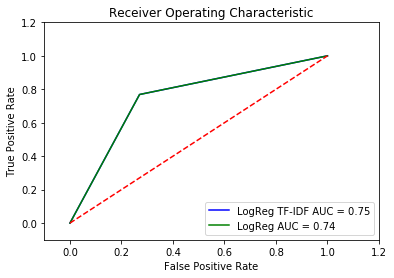

In [29]:
plt.title('Receiver Operating Characteristic')
plt.plot(logreg_tf_idf_false_positive_rate, logreg_tf_idf_true_positive_rate, 'b', label='LogReg TF-IDF AUC = %0.2f'% logreg_tf_idf_roc_auc)
plt.plot(logreg_tf_idf_false_positive_rate, logreg_tf_idf_true_positive_rate, 'g', label='LogReg AUC = %0.2f'% logreg_roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Рассмотрим подробнее разные виды NB и подберем альфа

In [82]:
size = 40
as_nb = np.empty(size)
as_bb = np.empty(size)
for i in xrange(1, size+1):
    tmp_alpha = float(i)/10
    nb = MultinomialNB(alpha=tmp_alpha)
    bb = BernoulliNB(alpha=tmp_alpha)
    nb.fit(X_train_dtm, y_train)
    bb.fit(X_train_dtm, y_train)
    preds_nb = nb.predict(X_test_dtm)
    preds_bb = bb.predict(X_test_dtm)
    as_nb[i-1] = accuracy_score(preds_nb, y_test)
    as_bb[i-1] = accuracy_score(preds_bb, y_test)
print as_nb.max(), float(as_nb.argmax()+1)/10
print as_bb.max(), float(as_bb.argmax()+1)/10

0.733582166316 2.4
0.732729864366 3.9


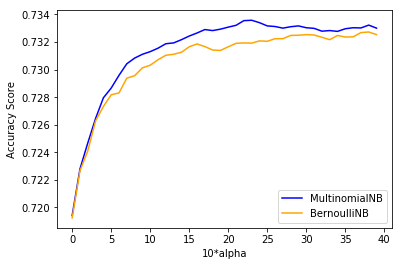

In [84]:
plt.plot(as_nb, 'b', label='MultinomialNB')
plt.plot(as_bb, 'orange', label='BernoulliNB')
plt.legend(loc='lower right')
plt.ylabel('Accuracy Score')
plt.xlabel('10*alpha')
plt.show()

## Load Twitts from dump

In [8]:
import json
import pandas as pd

In [5]:
DUMP_PATH_APPLE = 'TwitterSearchScrapper/dump/APPLE/apple_2017-09-01_2017-11-20'
DUMP_PATH_SECHIN = 'TwitterSearchScrapper/dump/СЕЧИН/Сечин_2017-01-01_2017-11-20'
DUMP_PATH_ROSN = 'TwitterSearchScrapper/dump/РОСНЕФТЬ/Роснефть_2017-09-01_2017-11-20'
DUMP_PATH_IPHONE = 'TwitterSearchScrapper/dump/IPHONE/iphone_2017-09-01_2017-11-20'
DUMP_PATH_MAIL = 'TwitterSearchScrapper/dump/MAIL.RU/Mail.ru_2017-09-01_2017-11-20'

In [6]:
data_apple = pd.read_json(DUMP_PATH_APPLE)
data_sechin = pd.read_json(DUMP_PATH_SECHIN)
data_rosn = pd.read_json(DUMP_PATH_ROSN)
data_iphone = pd.read_json(DUMP_PATH_IPHONE)
data_mail = pd.read_json(DUMP_PATH_MAIL)

In [7]:
total_test_data = pd.concat([data_apple, data_iphone, data_mail, data_rosn, data_sechin], axis=0)

In [9]:
total_test_data.shape

(56243, 18)

In [10]:
total_test_data.head()

,attach,favorites,id,link,mentions,quote,quote_id,replies,reply,reply_id,retweet,retweet_id,retweets,text,timestamp,user_id,user_name,user_username
0,False,0,903739658512846848,https://twitter.com/Jalilov1Alisher/status/903...,[],False,0,0,False,903739658512846848,False,0,0,Восстановление токопроводящих дорожек iPhone6 ...,2017-09-01 22:01:39,2393277684,Алишер,Jalilov1Alisher
1,False,0,903706496701272064,https://twitter.com/bobaleh/status/90370649670...,[],False,0,0,False,903706496701272064,False,0,0,Это что еще за? #apple #iphone pic.twitter.com...,2017-09-01 19:49:53,107208664,Илья Егоров,bobaleh
2,False,0,903705849574633472,https://twitter.com/carrot_23/status/903705849...,[],False,0,0,False,903705849574633472,False,0,0,Берёшь в руки 5 iPhone после 7ки и он такой не...,2017-09-01 19:47:19,465395891,Ksana Carrot,carrot_23
3,True,0,903704868346626048,https://twitter.com/rozumno/status/90370486834...,[],False,0,0,False,903704868346626048,False,0,0,#Apple претендует на 50% рынка «умных» часов б...,2017-09-01 19:43:25,2225566922,Веб-студия Rozum.no,rozumno
4,False,1,903703648605175808,https://twitter.com/iskovskih/status/903703648...,[],False,0,0,False,903703648605175808,False,0,0,12 сентября презентация #apple и буквально пар...,2017-09-01 19:38:34,390055117,Mike Iskovskih,iskovskih


In [11]:
total_test_data.to_csv('test_data.csv', sep=';')